# Zonal Statistics

RSGISLib is a set of Python modules which have been developed over the years to support our data processing needs.

The modules provide a set of high level functions, at a similar level to ArcGIS / QGIS toolbox functions or tools in ENVI or Erdas Imagine. The idea is that you can join a number of functions together to undertake your analysis or put those functions within a loop and process a number of input images.

In this tutorial we will look at populating various vector formats (points and polygons) from raster images for looking at fallow, growing and cropping cycles in agricultural/rice paddies in Vietnam, using radar imagery. Radar data is measured in backscatter where high values are associated with high structure (vegetation) and low values are associated with low structure (non_vegetated/water/bare).

You will learn the following:

- Extract raster values to point for specifc locations
- Extract raster statistics to buffered points (polygons)
- Extract raster stack statistics for agricultural fields (image objects)
- Explore extracted time-series signal

## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_



# 1. Importing Modules

The first step is to import the modules for the analysis we are to undertake:

In [1]:
# Import Geopandas for vector analysis (https://geopandas.org)
import geopandas

# Additional modules for visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Import Numpy array module
import numpy

# Import rsgislib modules
import rsgislib
import rsgislib.tools.plotting

# Note, you can import a list of modules rather than 
# listing each individually.
from rsgislib import imageutils, vectorutils, zonalstats

# 2. Data

Firstly, lets look at our imagery. Here you will find a stack of Sentinel-1 radar imagery captured over a small region of the Mekong Delta in Vietnam. Each band of the image is a monthly average over the course of a year, from January through December. The image is is linear radar units (power) but is scaled by 10,000. We can look at some basic image metadata and parameters using:

In [2]:
input_img = "../data/Sentinel1_MonthlyMean_2018_lin_100000_Geog_subset.tif"

In [3]:
# Call function to get the input image size:
x_size, y_size = rsgislib.imageutils.get_img_size(input_img)
print(f"Image dimensions: {x_size} x {y_size}")

# Call function to get the input image number of bands:
n_bands = rsgislib.imageutils.get_img_band_count(input_img)
print(f"Number of Bands: {n_bands}")

# Call function to get the input image band names:
band_names = rsgislib.imageutils.get_band_names(input_img)
print(f"Band Names: {band_names}")

# Call function to get the input image resolution:
x_res, y_res = rsgislib.imageutils.get_img_res(input_img)
print(f"Image Resolution: ({round(x_res, 2)}, {round(y_res,2)}) m")

Image dimensions: 1370 x 1180
Number of Bands: 12
Band Names: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Image Resolution: (10.0, -10.0) m


A point shapefile has been provided for you, which we will use to extrcat pixel values.

In [4]:
points_vec_file = "../data/sample_locations_utm.gpkg"

The first step is to check the number of field points that we have

In [5]:
feat_num = vectorutils.get_vec_feat_count(points_vec_file)
print(f"number of points: {feat_num}")

number of points: 24


Let us also use rsgislib tools to visualize the radar image with the points overlain. Try changing the band combination `bands=[1,2,3]` to visualise the different bands. Try `bands=[1]`, `bands=[2]`, `bands=[3]` and `bands=[6,7,8]`, for example.

Image Data Size: 1370 x 1180


<AxesSubplot:>

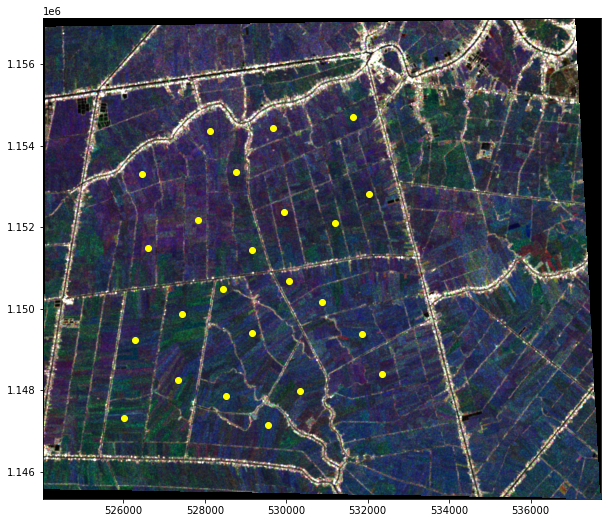

In [6]:
# Read image data
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[1, 2, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))
# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# Read points to geopandas dataframe
points_gdf = geopandas.read_file(points_vec_file)
# Plot the plots over the image data
points_gdf.plot(ax=ax, color="yellow")

# 3. Extract values to point

Firsty, let us consider the scenario whereby image values are needed at field plot locations. For a band of interest we can extract the pixel values at these point locations. 

We will start by reading the vector points into memory so it is stored as a vector object, using:

In [7]:
# Get list of layer names in vector file
vec_lyrs = rsgislib.vectorutils.get_vec_lyrs_lst(points_vec_file)
print(f"list of vector layers: {vec_lyrs}")

# Get first name from vec_lyrs list
lyr_name = vec_lyrs[0]

# Read vector layer to memory
vec_ds_obj, vec_lyr_obj = rsgislib.vectorutils.read_vec_lyr_to_mem(
    points_vec_file, lyr_name
)

list of vector layers: ['sample_locations_utm']


This creates a vector layer objet (vec_lyr_obj) which stores the vector in memory. Next we will define the input parameters for the extract to point command.

In [8]:
# The image band in the raster stack
img_band = 2
# The minimum value that the point will extract
min_thres = 1
# The maximum value that the point will extract
max_thres = 10000
# The no data value which will not be extracted, but will be used in the case where there is no valid pixel value
out_no_data_val = 0
# The name of the output field in the att table
out_field = "February"
# whether to reproject the vector on-the-fly to match the image
reproj_vec = False
# Specify the epsg for the vector if the WKT is not well defined
vec_def_epsg = None

rsgislib.zonalstats.ext_point_band_values(
    vec_lyr_obj,
    input_img,
    img_band,
    min_thres,
    max_thres,
    out_no_data_val,
    out_field,
    reproj_vec,
    vec_def_epsg,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 949.18it/s]


Now that we have extrcated the pixel values, the final step is to write the vector layer back to the points shapefile.

In [9]:
# The layer in memory which now had pixel attributes
mem_lyr = vec_lyr_obj
# the output file to write the data to.
points_stats_vec_file = "sample_locations_utm_stats.gpkg"
# OGR layer name (matches input layer name in this case)
layer_name = lyr_name
# OGR format. Should match input type if overwriting
ogr_format = "GPKG"

rsgislib.vectorutils.write_vec_lyr_to_file(
    mem_lyr,
    points_stats_vec_file,
    layer_name,
    ogr_format,
    options=["OVERWRITE=YES", "SPATIAL_INDEX=YES"],
)

While this shows how layers can be read into memory, populated and written back to a shapefile (GeoPackage), this is mostly used when lots of image values are populated into dataset in one go. RSGISLib also has a function to achieve our workflow in one step using the command: ext_point_band_values

Now we have written the updated layer to the dataset, we can open the vector and look at the values we have extracted:

In [10]:
# Open the gpkg file with geopandas
gdf = geopandas.read_file(points_stats_vec_file)

# View the first 5 attributes
gdf.head()

,id,february,geometry
0,0,1349.0,POINT (526459.321 1153316.974)
1,1,1303.0,POINT (526604.807 1151498.406)
2,2,1468.0,POINT (527441.348 1149861.694)
3,3,684.0,POINT (529950.972 1152371.318)
4,4,1121.0,POINT (529678.187 1154426.301)


# 4. Extract image statistics within a polygon

Extracting values to a point location is useful, but it is not always known if the pixel value represents the point location accuratley. Often it is preferred that a number of pixels are sampled and represented by a single statistic (e.g., mean) which may be more representative and reduces error due to geolocation etc.

To do this, firstly we need to buffer our points to get polygons. We will buffer our points by 100 m.

The points vector is already open from the above step:

gdf = gpd.read_file(points_vec_file)

Therefore we can buffer the points with:

In [11]:
# Buffer the points geometry with 100 m
gdf["geometry"] = gdf.geometry.buffer(100)

# Buffered points output file name and path
buffered_points_vec_file = "sample_locations_utm_buffer100.gpkg"

# Write the buffered points to a new file with points buffered by 100 m
gdf.to_file(buffered_points_vec_file, "GPKG")

/Users/pete/miniforge3/envs/osgeo-env-v2/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


We can visualize the buffered points (yellow) behind our original points on a figure using:

<AxesSubplot:>

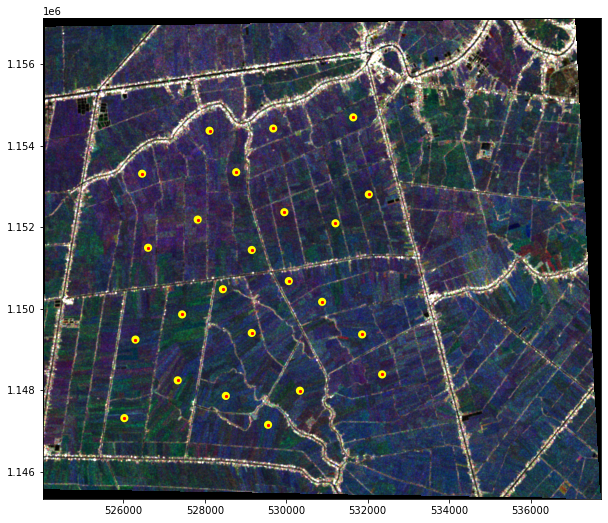

In [12]:
# We already opened the image and calculated the image stretch parameters from
# stretch parameters from the first visualization

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))
# Add the stretched image from visualization above data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# Read points to geopandas dataframe
buff_points_gdf = geopandas.read_file(buffered_points_vec_file)

# Plot the buffered plots and points over the image data
buff_points_gdf.plot(ax=ax, color="yellow")
points_gdf.plot(ax=ax, color="red", markersize=5)

Now that we have buffered points we can now use commands within RSGISLib to extract image statistics from image pixels that are overlapped by the polygons. Each pixel below the polygon will be included in the statistics, provided that the polygon intersects the pixel centroid (middle point).

We begin again by getting the vector layer name that we want to use:

In [13]:
# Get list of layer names in vector file
vec_lyrs = rsgislib.vectorutils.get_vec_lyrs_lst(buffered_points_vec_file)
# Get first name from vec_lyrs list
lyr_name = vec_lyrs[0]
print(f"layer name: {lyr_name}")

layer name: sample_locations_utm_buffer100


As we know that the pixel size is smaller than our polygons, we can use the following command to get the min, max and mean pixel values. Here we will not read the layer into memory first as we extracting values from only one image band so we will use the following command:

In [14]:
# vector file
vec_file = buffered_points_vec_file
# vector layer name
vec_lyr = lyr_name
# raster stack image band
img_band = 2
# The minimum value that the point will extract
min_thres = 1
# The maximum value that the point will extract
max_thres = 10000
# The no data value which will not be extracted, but will be used in the case where there is no valid pixel value
out_no_data_val = 0
# The name of the output fields to write to the att table
mean_field_name = "Feb_mean"
min_field_name = "Feb_min"
max_field_name = "Feb_max"
# Specify the epsg for the vector if the WKT is not well defined
vec_def_epsg = None

rsgislib.zonalstats.calc_zonal_band_stats_test_poly_pts_file(
    vec_file=buffered_points_vec_file,
    vec_lyr=lyr_name,
    input_img=input_img,
    img_band=2,
    min_thres=1,
    max_thres=10000,
    out_no_data_val=0,
    min_field=min_field_name,
    max_field=max_field_name,
    mean_field=mean_field_name,
)

300it [00:00, 2769.02it/s]                                                                                                                                                                 


We can now look at these pixel stats in the attribute table of the vector

In [15]:
# Open the gpkg file with geopandas
gdf = geopandas.read_file(buffered_points_vec_file)

# View the first 5 attributes
gdf.head()

,id,february,feb_min,feb_max,feb_mean,geometry
0,0,1349.0,803.0,2083.0,1315.438710,"POLYGON ((526559.321 1153316.974, 526558.840 1..."
1,1,1303.0,903.0,2986.0,1618.439490,"POLYGON ((526704.807 1151498.406, 526704.325 1..."
2,2,1468.0,858.0,2538.0,1571.277070,"POLYGON ((527541.348 1149861.694, 527540.867 1..."
3,3,684.0,429.0,2484.0,1126.662420,"POLYGON ((530050.972 1152371.318, 530050.491 1..."
4,4,1121.0,906.0,2393.0,1500.083067,"POLYGON ((529778.187 1154426.301, 529777.706 1..."


Here we can see the column 'february' which was extracted to the points vector file and the three february statistics that were populated inot the polygons (buffered points)

# 5. Time-series zonal stats analysis

We have seen how you can populate polygons with statistics from an image. Now we will look at an applied example, where we will look at time-series signals from agricultural fields to understand cropping cycles. We will look specifically at a region in the Mekong Delta of Vietnam and evaluate how many cropping cycles there are over the course of a year. This example is taken from work in:  https://doi.org/10.3390/rs12203459

You have been provided with a shapefile of field boundaries created from VHR Worldview imagery. We will begin by looking at this shapefile and the Sentinal-1 radar imagery that we have used so far in this tutorial.

---
In this case as the GPKG file with the field boundaries is quite large as an uncompressed file we will read it as a compressed dataset. Note, to do this we have to reference the file path slightly differently, specifying the path as a zip compressed file and then the path within the zip file to the GPKG file we are wanting to open.

You cannot write to a zipped vector layer but if the layer is only going to be used for reading and not to be written to it can save a lot of disk space! In this case `tile_segs_mskd_lbl_vec111.gpkg.zip` is **87 %** smaller than `tile_segs_mskd_lbl_vec111.gpkg`.

---

<AxesSubplot:>

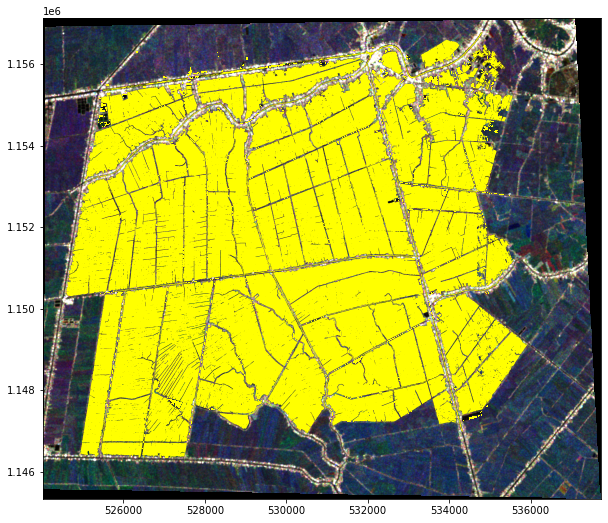

In [16]:
# Field polygons - Note. /vsizip/ specifies that we are openning a zip file.
# The path to the zip file is: ../data/tile_segs_mskd_lbl_vec111.gpkg.zip
# The path to the GPKG file we want to open within the zip file is:
# tile_segs_mskd_lbl_vec111.gpkg
in_field_vec = (
    "/vsizip/../data/tile_segs_mskd_lbl_vec111.gpkg.zip/tile_segs_mskd_lbl_vec111.gpkg"
)

# Read points to geopandas dataframe
field_polys = geopandas.read_file(in_field_vec)

# We already opened the image and calculated the image stretch parameters from
# stretch parameters from the first visualization

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))
# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)


# Plot the fields over the image data
field_polys.plot(ax=ax, color="yellow")

Here we will replicate the zonal statistics like in section 4, but will iterate the command over each image band.

First we need the vector layer name:

In [17]:
# Get list of layer names in vector file
vec_lyrs = rsgislib.vectorutils.get_vec_lyrs_lst(in_field_vec)

# Get first name from vec_lyrs list
lyr_name = vec_lyrs[0]
print(f"layer name: {lyr_name}")

layer name: tile_segs_mskd_lbl_vec111


We will now need to create a list to iterate over each band of the image and assign a unique field name for each image band:

In [18]:
# Create an array of image band numbers using the module numpy
image_bands = numpy.arange(1, 13, 1)
print(f"image bands: {image_bands}")

# Create a list of attribute fields we will populate
out_fields_list = [
    "jan_mean",
    "feb_mean",
    "mar_mean",
    "apr_mean",
    "may_mean",
    "jun_mean",
    "jul_mean",
    "aug_mean",
    "sep_mean",
    "oct_mean",
    "nov_mean",
    "dec_mean",
]

image bands: [ 1  2  3  4  5  6  7  8  9 10 11 12]


As we are reading 12 bands into the layer, it would be inefficient to do this in the same manner as above as we will have to read, populate and write the vector each time. Instead, it is more efficient to read the layer into memory once, populate the values and write out the data once.

We will start by reading the layer into memory:

In [19]:
# Read vector layer to memory
vec_ds_obj, vec_lyr_obj = rsgislib.vectorutils.read_vec_lyr_to_mem(
    in_field_vec, lyr_name
)

We can now iterate over these lists, running the command a total of 12 times:

In [20]:
# set the command constants
# memory object
mem_obj = vec_lyr_obj

# set up a for loop to iterate over the image bands list and execute the command
for band in image_bands:
    # specify the image band
    img_band_num = int(band)
    print(f"band number = {img_band_num}")
    # specify the out field (out fields list indexed to band, minus 1)
    mean_field_name = out_fields_list[band - 1]
    print(f"out field name = {mean_field_name}")
    # Run the command
    rsgislib.zonalstats.calc_zonal_band_stats_test_poly_pts(
        mem_obj,
        input_img,
        img_band=img_band_num,
        min_thres=1,
        max_thres=10000,
        out_no_data_val=0,
        min_field=None,
        max_field=None,
        mean_field=mean_field_name,
    )

band number = 1
out field name = jan_mean


68265it [00:01, 47839.21it/s]                                                                                                                                                              


band number = 2
out field name = feb_mean


68265it [00:01, 46702.63it/s]                                                                                                                                                              


band number = 3
out field name = mar_mean


68265it [00:01, 47340.37it/s]                                                                                                                                                              


band number = 4
out field name = apr_mean


68265it [00:01, 48942.85it/s]                                                                                                                                                              


band number = 5
out field name = may_mean


68265it [00:01, 55383.56it/s]                                                                                                                                                              


band number = 6
out field name = jun_mean


68265it [00:01, 53148.58it/s]                                                                                                                                                              


band number = 7
out field name = jul_mean


68265it [00:01, 48879.87it/s]                                                                                                                                                              


band number = 8
out field name = aug_mean


68265it [00:01, 50459.76it/s]                                                                                                                                                              


band number = 9
out field name = sep_mean


68265it [00:01, 50505.91it/s]                                                                                                                                                              


band number = 10
out field name = oct_mean


68265it [00:01, 55530.70it/s]                                                                                                                                                              


band number = 11
out field name = nov_mean


68265it [00:01, 55670.31it/s]                                                                                                                                                              


band number = 12
out field name = dec_mean


68265it [00:01, 55773.90it/s]                                                                                                                                                              


These values are held in the memory object so should be written back to a new file to save them without overwriting the original file:

In [21]:
# Memory object
mem_obj_vec = mem_obj
# output vector file path - changed to not overwrite the input file
field_stats_vec = "tile_segs_mskd_lbl_vec111_stats.gpkg"
# out layer name (same as input)
layer_name = lyr_name
# Vector format
vec_format = "GPKG"

rsgislib.vectorutils.write_vec_lyr_to_file(
    mem_obj_vec,
    field_stats_vec,
    layer_name,
    vec_format,
    options=["OVERWRITE=YES", "SPATIAL_INDEX=YES"],
)

Now we can look at the attribute table that we have populated:

In [22]:
# Open the gpkg file with geopandas
gdf = geopandas.read_file(field_stats_vec)

# View the first 5 attributes
gdf.head()

,PXLVAL,jan_mean,feb_mean,mar_mean,apr_mean,may_mean,jun_mean,jul_mean,aug_mean,sep_mean,oct_mean,nov_mean,dec_mean,geometry
0,5,3172.352941,2479.117647,3094.176471,4351.117647,3726.588235,4496.176471,4792.176471,3693.176471,2411.647059,2672.058824,3844.470588,3897.764706,"POLYGON ((532134.492 1156436.492, 532134.492 1..."
1,6,2486.085714,2324.857143,3156.200000,3128.600000,3476.657143,4412.142857,5168.257143,4882.885714,6055.914286,5711.200000,5702.228571,5334.742857,"POLYGON ((532505.492 1156397.492, 532505.492 1..."
2,8,4942.500000,3802.833333,4111.916667,3104.416667,4027.083333,3893.000000,3644.333333,3000.083333,3041.833333,3801.750000,4343.166667,3878.083333,"POLYGON ((531670.492 1156360.492, 531670.492 1..."
3,7,1890.520000,1581.840000,1601.240000,1685.840000,1877.640000,2167.840000,1929.240000,1922.880000,1925.080000,1929.640000,1933.480000,1857.880000,"POLYGON ((532460.492 1156367.492, 532460.492 1..."
4,12,4650.000000,4420.437500,3629.875000,4023.812500,4434.437500,3888.062500,3813.875000,3983.500000,3958.687500,4495.250000,4400.125000,3953.625000,"POLYGON ((526327.492 1156328.492, 526327.492 1..."


### Time-series analysis

For this we will look at one specific field, by selecting a specific row (field) from the geopandas dataframe. Here we will use a combination of geopandas, numpy and matplotlib (within geopandas) to show how rsgisliob can be combined with other python modules for you to  complete your analysis

In [23]:
# read row (field) number 207 and remove the FID and geometry info which are not needed
field = gdf.iloc[207].drop(["PXLVAL", "geometry"])
print(field)

jan_mean     1621.33506
feb_mean    1627.199291
mar_mean    2770.824427
apr_mean    2423.172846
may_mean    1635.747001
jun_mean    1573.271265
jul_mean    3109.101145
aug_mean    2913.543893
sep_mean    1323.565431
oct_mean    1956.055616
nov_mean    2615.757088
dec_mean    2262.254089
Name: 207, dtype: object


Which is visualized here:

<AxesSubplot:>

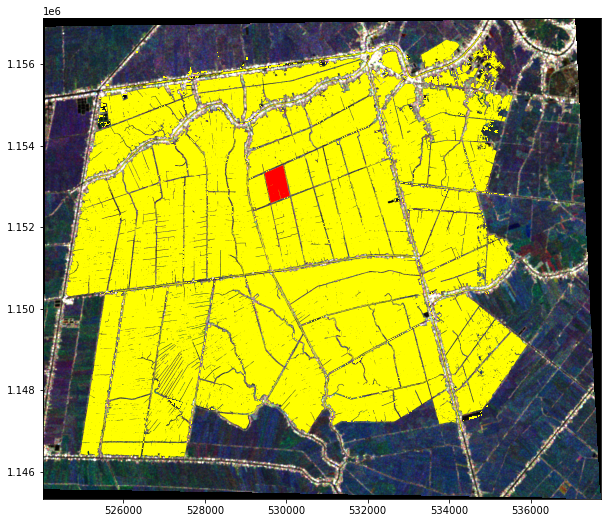

In [24]:
# We already opened the image and calculated the image stretch parameters from
# stretch parameters from the first visualization

# The fields vector file was read in above to look at the attribute table

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))
# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)
# Plot the fields over the image data
field_polys.plot(ax=ax, color="yellow")
# plot the field location geometry
gdf.loc[[207], "geometry"].plot(ax=ax, color="red")

Make a list of the 12 months of data from the dataframe

In [25]:
# Convert the dataframe to a list, ignoring the fid [0] and geometry [-1]
field_vals = field.to_numpy().astype(float)
field_vals

array([1621.33505998, 1627.19929117, 2770.82442748, 2423.17284624,
       1635.74700109, 1573.27126499, 3109.10114504, 2913.54389313,
       1323.56543075, 1956.05561614, 2615.75708833, 2262.25408942])

The values we currently have are in linear power and multiplied by a scale factor of 10000. We should convert these values to decibel for plotting and visualization.

Firstly we will remove the scale factor:

In [26]:
# divide by 10000
field_vals_pwr = field_vals / 10000
field_vals_pwr

array([0.16213351, 0.16271993, 0.27708244, 0.24231728, 0.1635747 ,
       0.15732713, 0.31091011, 0.29135439, 0.13235654, 0.19560556,
       0.26157571, 0.22622541])

We can now convert these values to log decibel (dB) using the standard formula:

$10*log10(x^2)$

In [27]:
field_vals_dB = 10 * numpy.log(field_vals_pwr ** 2)
field_vals_dB

array([-36.38670344, -36.31449565, -25.6688038 , -28.35014636,
       -36.20971023, -36.98856066, -23.36502859, -24.6642984 ,
       -40.44511828, -32.63310176, -26.8206304 , -29.72446784])

We can plot this data like this:

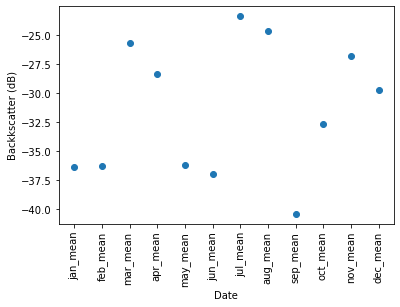

In [28]:
plt.scatter(out_fields_list, field_vals_dB)
plt.xlabel("Date")
plt.ylabel("Backkscatter (dB)")
plt.xticks(rotation=90)
plt.show()

Finally, we can use the scipy module to fit a curve to our data points so we can better visualize the trend:

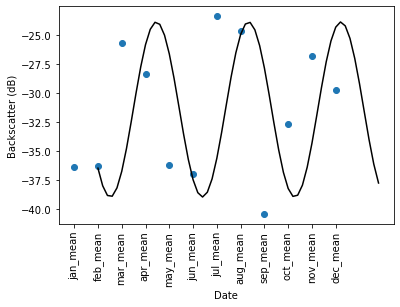

In [29]:
from scipy.optimize import curve_fit


# Fourier Series 1 Term (scaled X) from zunzun.com
def func(x, offset, a1, b1, c1):
    return a1 * numpy.sin(c1 * x) + b1 * numpy.cos(c1 * x) + offset


# these are the same as the scipy defaults
init_parameters = numpy.array([1.0, 1.0, 1.0, 1.0])

x_axis = numpy.arange(1, 13, 1)
x_model = numpy.arange(1, 13, 0.2)

fitted_parameters, pcov = curve_fit(func, x_axis, field_vals_dB, init_parameters)

model_predictions = func(x_model, *fitted_parameters)
mdl_pred = func(x_axis, *fitted_parameters)

plt.scatter(out_fields_list, field_vals_dB)
plt.plot(x_model, model_predictions, c="black")
plt.xlabel("Date")
plt.ylabel("Backscatter (dB)")
plt.xticks(rotation=90)
plt.show()

Here we can see that there are three distinct peaks associated with cropping cyles. The Mekong Delta is one of the only places on Earth where three rice cropping cycles are possible.